# Automating Flow Cytometry Data Analysis

**USD M.Sc. Applied Data Science Capstone Project** \
*Shiley-Marcos School of Engineering* \


Gabriella Rivera\
John Vincent Deniega \
Date: 26Oct2024 \


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vanguardfox/ADS599/blob/main/ADS599.ipynb)

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install packages:

In [3]:
#!pip install FlowCal
#!pip install flowio

Import libraries:

In [4]:
import FlowCal
import flowio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pandas as pd
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

Handle Warnings

In [ ]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

## Flow Cytometry Data General Information

Selected cellular surface markers to identify target Dendritic Cells (DC): Myeloid DC and Plasmacytoid DC.

| Marker | Fluorochrome | Description |
|--------|--------------|--------------|
| CD45RA | Ax700 | An isoform of CD45, marking naïve T cells that haven't encountered their antigen
| HLA-DR | BV786 | An MHC class II molecule presenting antigens to CD4+ T cells; indicates antigen-presenting cells (APCs)
| CD3 | APC-H7 | Part of the T-cell receptor complex, essential for T cell activation; found on all T cells
| CD20 | BUV805 | A B cell marker involved in activation and proliferation; used to identify B cells
| CD19 | PE-Cy5 | A co-receptor for B cell activation, primarily expressed on B cells
| CD14 | BV510 | A co-receptor for LPS, marking monocytes and macrophages involved in innate immunity
| CD123 | BB660 | The alpha chain of the IL-3 receptor, found on plasmacytoid dendritic cells and progenitor cells
| CD11c | APC | An integrin marking dendritic cells and certain macrophages, important for cell adhesion and activation

**Cellular Pathway:**

1. *PBMCs (Peripheral Blood Mononuclear Cells)* \
   Starting population

2. *CD3-* \
   Excludes T cells, focusing on B cells and myeloid cells

3. *CD19- & CD20-*  \
   Excludes B cells, narrowing down to monocytes and dendritic cells

4. *CD14-*  \
   Further excludes monocytes, leading to dendritic cell populations

5. *HLA-DR+*  \
   Identifies antigen-presenting cells (APC)

6. *CD11c+ (Myeloid DC)*  \
   Indicates myeloid dendritic cells  \

  **OR**
   
   *CD123+ (Plasmacytoid DC)*   \
   Indicates plasmacytoid dendritic cells


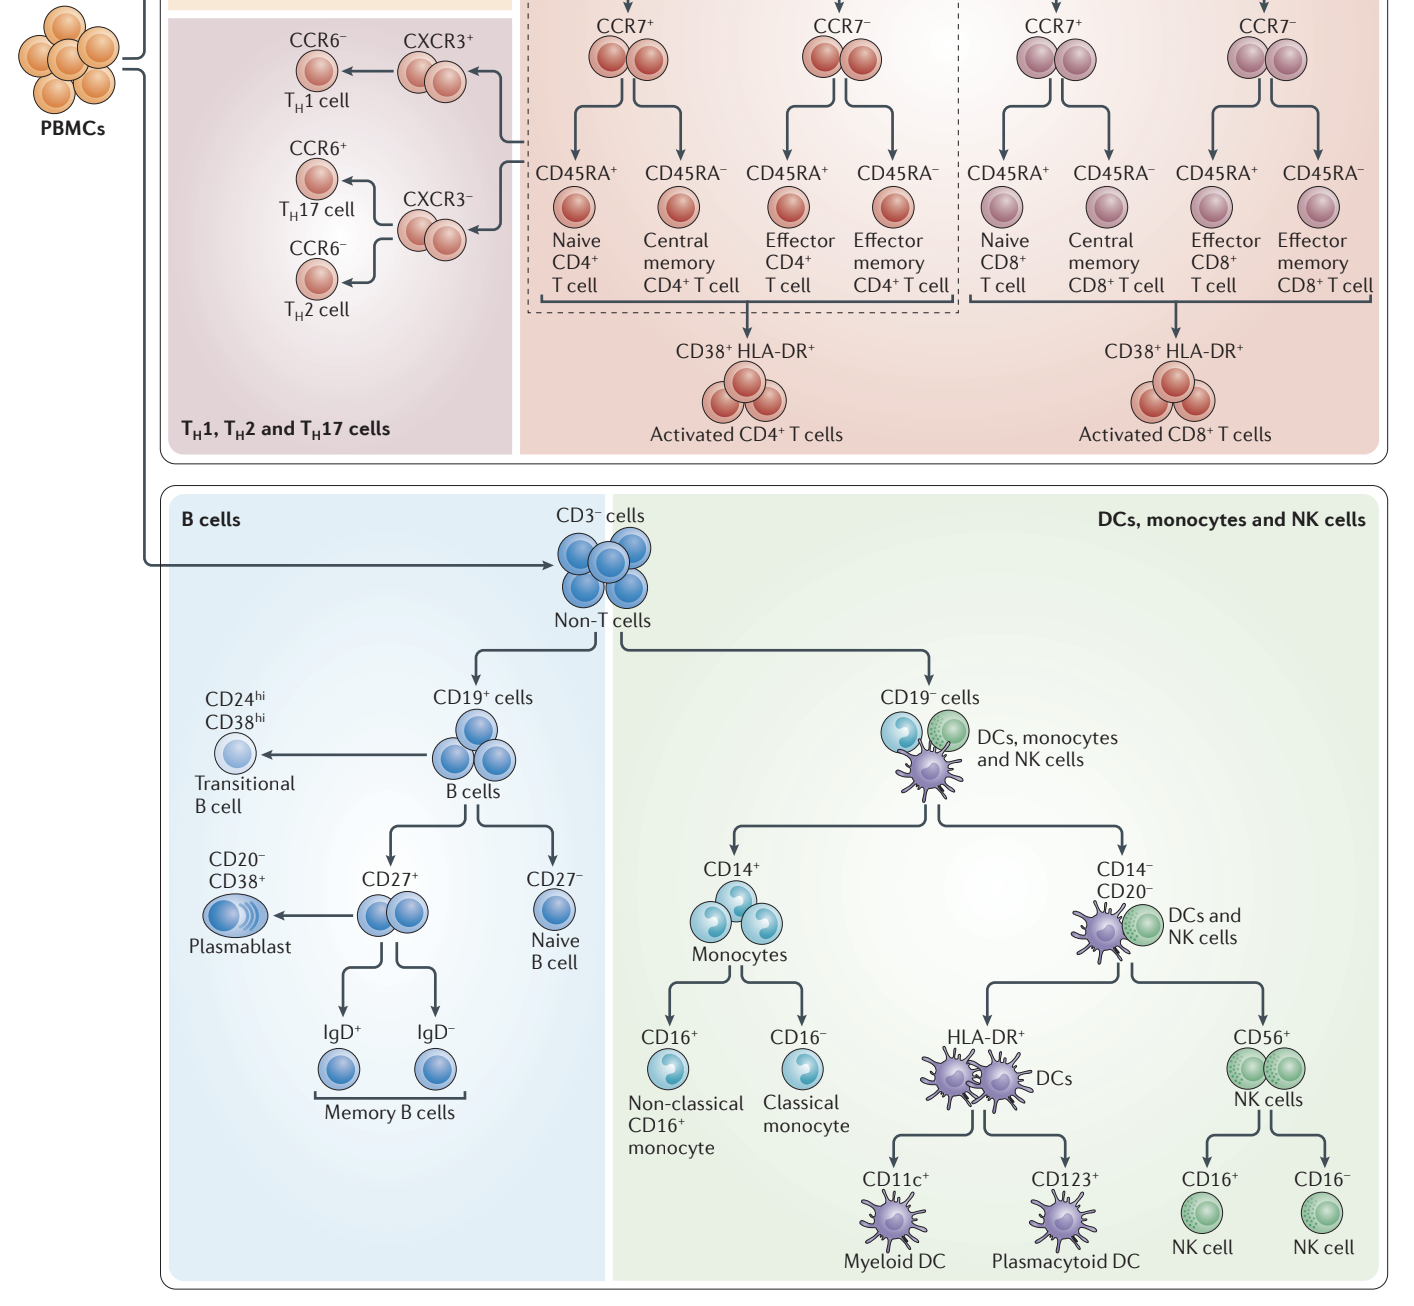

## Flow Cytometry Data Extraction

Import datasets:

In [30]:
# User's MyDrive paths
JV = "/content/drive/MyDrive/Colab_Notebooks/ADS599"
GR = "/content/drive/MyDrive/DC Marker Files/FCS"

In [31]:
# Define the path to the FCS file
fcs_folder = GR
pbmc_file = "PBMC_090120_1_DCs_A5_A05_031.fcs"
pbmc_path = os.path.join(fcs_folder, pbmc_file)
save_folder = GR

# Load the FCS data into an object
pbmc = FlowCal.io.FCSData(pbmc_path)

# Inspect available attributes
print("Available attributes of FCSData:")
for attr in dir(pbmc):
    if not attr.startswith('_'):
        print(attr)

Available attributes of FCSData:
T
acquisition_end_time
acquisition_start_time
acquisition_time
all
amplification_type
amplifier_gain
analysis
any
argmax
argmin
argpartition
argsort
astype
base
byteswap
channel_labels
channels
choose
clip
compress
conj
conjugate
copy
ctypes
cumprod
cumsum
data
data_type
detector_voltage
diagonal
dot
dtype
dump
dumps
fill
flags
flat
flatten
getfield
hist_bins
imag
infile
item
itemset
itemsize
max
mean
min
nbytes
ndim
newbyteorder
nonzero
partition
prod
ptp
put
range
ravel
real
repeat
reshape
resize
resolution
round
searchsorted
setfield
setflags
shape
size
sort
squeeze
std
strides
sum
swapaxes
take
text
time_step
tobytes
tofile
tolist
tostring
trace
transpose
var
view


In [32]:
# Access the channel labels by calling the method
marker_labels = pbmc.channel_labels()

# Print the marker labels
print("Marker Labels:", marker_labels)

Marker Labels: [None, None, None, 'CADM1 FITC', 'CD141 BB630', 'CD123 BB660', 'FcER1a BB700', None, 'XCR1 BV421', 'CD14 BV510', 'CD16 BV570', None, 'CD172a BV650', None, 'CD303 BV750', 'HLA-DR BV786', 'CD1c BUV395', 'Live Dead UV Blue', None, 'CD56 BUV563', 'CD89 BUV661', 'CD163 BUV737', 'CD20 BUV805', 'CD11c APC', 'CD45RA Ax700', 'CD3 APC-H7', 'CD301 PE', None, 'CD19 PE-Cy5', 'CD5 PE-Cy55', 'CD88 PE-Cy7', None]


In [33]:
# Convert pbmc to little-endian float32
if pbmc.dtype != '<f4':
    pbmc = np.array(pbmc, dtype='<f4')

# Replace the first three column labels with specified values
marker_labels[0] = "FSC-A"
marker_labels[1] = "FSC-H"
marker_labels[2] = "SSC-A"
marker_labels[31] = "Time"

# Convert the FCS data to a Pandas DataFrame
pbmc_s1_df = pd.DataFrame(pbmc)

# Assign marker labels to the DataFrame columns
pbmc_s1_df.columns = marker_labels

# Extract the 'Time' data and scale it
pbmc_s1_df['Time'] = pbmc_s1_df['Time'] * 0.01

# Convert all columns to float32 (little-endian), except 'Time'
numeric_columns = pbmc_s1_df.columns.difference(['Time'])

# Use astype to convert and force little-endian byte order for numeric columns
pbmc_s1_df[numeric_columns] = pbmc_s1_df[numeric_columns].astype('<f4')

# Save the formatted DataFrame as a CSV file
output_file = "pbmc_s1.csv"
save_folder = "/content"
output_path = os.path.join(save_folder, output_file)
pbmc_s1_df.to_csv(output_path, index=False)

In [34]:
# PBMC Dataframe
pbmc_s1_df.head()

,FSC-A,FSC-H,SSC-A,CADM1 FITC,CD141 BB630,CD123 BB660,FcER1a BB700,None,XCR1 BV421,CD14 BV510,...,CD20 BUV805,CD11c APC,CD45RA Ax700,CD3 APC-H7,CD301 PE,None,CD19 PE-Cy5,CD5 PE-Cy55,CD88 PE-Cy7,Time
0,87361.875000,79434.132812,598.278687,160.180847,59.948257,265.052338,2209.889160,618.392395,86.726891,135.512466,...,263.738281,134.774185,2193.238281,1619.123413,502.208740,186.362259,161.581375,3681.024658,3134.778076,0.036351
1,126908.382812,108476.132812,1030.258667,202.591660,1682.306030,2094.691162,4600.433594,1695.130615,1039.571655,1021.779724,...,1318.864380,1797.314941,3525.506836,677.857422,5200.446777,3191.416504,642.054871,2521.566406,2330.867432,0.036405
2,80773.437500,72883.585938,460.699219,63.809006,41.512314,187.331284,1758.511597,564.467651,85.910072,132.620850,...,163.514221,136.576172,2556.105469,1337.768311,291.157410,116.808624,78.402611,3396.210205,2594.312744,0.036667
3,98579.289062,90491.320312,798.337646,180.572540,584.399658,4503.693359,10570.937500,4350.170410,1614.768921,780.501343,...,487.675171,2861.196289,4038.256348,650.127197,547.439514,503.161377,774.617554,3809.564453,5784.430176,0.036894
4,81687.250000,74994.593750,586.497864,156.943649,-2.742810,89.636864,1083.409912,343.418365,75.981934,173.593552,...,174.489120,77.228905,3129.699219,1420.843384,196.809097,97.804459,122.227951,2326.320801,2200.183838,0.037151


In [35]:
# PBMC General Info
pbmc_s1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2088689 entries, 0 to 2088688
Data columns (total 32 columns):
 #   Column             Dtype  
---  ------             -----  
 0   FSC-A              float32
 1   FSC-H              float32
 2   SSC-A              float32
 3   CADM1 FITC         float32
 4   CD141 BB630        float32
 5   CD123 BB660        float32
 6   FcER1a BB700       float32
 7   None               float32
 8   XCR1 BV421         float32
 9   CD14 BV510         float32
 10  CD16 BV570         float32
 11  None               float32
 12  CD172a BV650       float32
 13  None               float32
 14  CD303 BV750        float32
 15  HLA-DR BV786       float32
 16  CD1c BUV395        float32
 17  Live Dead UV Blue  float32
 18  None               float32
 19  CD56 BUV563        float32
 20  CD89 BUV661        float32
 21  CD163 BUV737       float32
 22  CD20 BUV805        float32
 23  CD11c APC          float32
 24  CD45RA Ax700       float32
 25  CD3 APC-H7        

## Data Preprocessing or Data Wrangling

In [38]:
# Upload Dataset from Google Drive
pbmc_s1_df = pd.read_csv("pbmc_s1.csv")

# Round all columns to 3 decimal places
pbmc_s1_df = pbmc_s1_df.round(4)

# Display the shape of the DataFrame
print("Number of Original instances and features:", pbmc_s1_df.shape)

Number of Original instances and features: (2088689, 32)


In [39]:
pbmc_s1_df.head()

,FSC-A,FSC-H,SSC-A,CADM1 FITC,CD141 BB630,CD123 BB660,FcER1a BB700,Unnamed: 7,XCR1 BV421,CD14 BV510,...,CD20 BUV805,CD11c APC,CD45RA Ax700,CD3 APC-H7,CD301 PE,Unnamed: 27,CD19 PE-Cy5,CD5 PE-Cy55,CD88 PE-Cy7,Time
0,87361.875,79434.130,598.2787,160.1808,59.9483,265.0523,2209.8892,618.3924,86.7269,135.5125,...,263.7383,134.7742,2193.2383,1619.1234,502.2087,186.3623,161.5814,3681.0247,3134.7780,0.0364
1,126908.380,108476.130,1030.2587,202.5917,1682.3060,2094.6912,4600.4336,1695.1306,1039.5717,1021.7797,...,1318.8644,1797.3150,3525.5068,677.8574,5200.4470,3191.4165,642.0549,2521.5664,2330.8674,0.0364
2,80773.440,72883.586,460.6992,63.8090,41.5123,187.3313,1758.5116,564.4677,85.9101,132.6208,...,163.5142,136.5762,2556.1055,1337.7683,291.1574,116.8086,78.4026,3396.2102,2594.3127,0.0367
3,98579.290,90491.320,798.3377,180.5725,584.3997,4503.6934,10570.9375,4350.1704,1614.7689,780.5013,...,487.6752,2861.1963,4038.2563,650.1272,547.4395,503.1614,774.6176,3809.5645,5784.4300,0.0369
4,81687.250,74994.590,586.4979,156.9436,-2.7428,89.6369,1083.4099,343.4184,75.9819,173.5936,...,174.4891,77.2289,3129.6992,1420.8434,196.8091,97.8045,122.2280,2326.3208,2200.1838,0.0372


In [40]:
# Remove unnamed columns
pbmc_s1_df = pbmc_s1_df.loc[:, ~pbmc_s1_df.columns.str.contains('^Unnamed')]

# Display the shape of the DataFrame after filtering
print("Number of instances and features after filtering:", pbmc_s1_df.shape)

Number of instances and features after filtering: (2088689, 27)


In [41]:
# Remove unnecessary features
pbmc_s1_df = pbmc_s1_df.drop(columns=['CADM1 FITC', 'CD141 BB630', 'FcER1a BB700',
                                      'XCR1 BV421', 'CD16 BV570', 'CD172a BV650',
                                      'CD303 BV750', 'CD1c BUV395', 'CD56 BUV563',
                                      'CD89 BUV661', 'CD163 BUV737', 'CD301 PE',
                                      'CD5 PE-Cy55', 'CD88 PE-Cy7'])

# Display the shape of the DataFrame after filtering
print("Number of instances  and features after filtering:", pbmc_s1_df.shape)

Number of instances  and features after filtering: (2088689, 13)


In [61]:
# Remove instances where Time is gated
pbmc_s1_df = pbmc_s1_df[(pbmc_s1_df['Time'] > 3) &
                        (pbmc_s1_df['Time'] < 215)
                        ]

# Display the shape of the DataFrame after filtering
print("Number of instances after filtering:", pbmc_s1_df.shape[0])

Number of instances after filtering: 2035056


In [62]:
# Remove instances where FSC is at a certain threshold
pbmc_s1_df = pbmc_s1_df[(pbmc_s1_df['FSC-A'] > 20000) &
                        (pbmc_s1_df['FSC-H'] < 200000) &
                        (pbmc_s1_df['FSC-A'] < 550000)
                        ]

# Display the shape of the DataFrame after filtering
print("Number of instances after filtering:", pbmc_s1_df.shape[0])

Number of instances after filtering: 1958049


In [63]:
# Remove instances where SSC is at a certain threshold
pbmc_s1_df = pbmc_s1_df[(pbmc_s1_df['SSC-A'] > 110) &
                         (pbmc_s1_df['SSC-A'] < 20000)
                         ]

# Display the shape of the DataFrame after filtering
print("Number of instances after filtering:", pbmc_s1_df.shape[0])

Number of instances after filtering: 1956288


In [64]:
# Remove instances where Live Dead UV Blue is below a certain threshold
pbmc_s1_df = pbmc_s1_df[(pbmc_s1_df['Live Dead UV Blue'] > 350)]

# Display the shape of the DataFrame after filtering
print("Number of instances after filtering:", pbmc_s1_df.shape[0])

Number of instances after filtering: 1045518


In [65]:
# Save the formatted DataFrame as a CSV file
output_file = "pbmc_clean.csv"
save_folder = "/content"
output_path = os.path.join(save_folder, output_file)
pbmc_s1_df.to_csv(output_path, index=False)

## Exploratory Data Analysis

In [48]:
# Upload Dataset from Google Drive
pbmc_c = pd.read_csv("pbmc_s1.csv")

# Select a random sample at set instances
sample_size = 100000
pbmc_r = pbmc_c.sample(n=sample_size, random_state=42)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


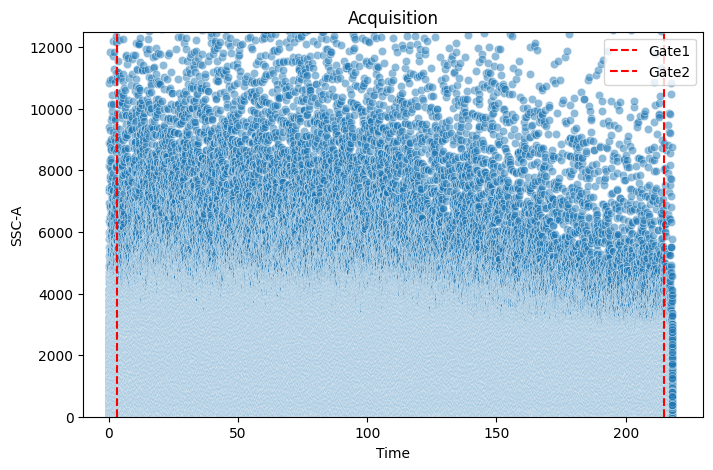

In [60]:
# Create the scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pbmc_c, x='Time', y='SSC-A', alpha=0.5)

# Set plot labels and title
plt.title('Acquisition')
plt.xlabel('Time')
plt.ylabel('SSC-A')

# Set x and y axis limits
plt.xlim(-10, 230)
plt.ylim(0, 12500)

# Determine the x-value for the vertical lines
x_lim1 = 3    # Change this value based on the data
x_lim2 = 215  # Change this value based on the data

# Draw the vertical lines
plt.axvline(x=x_lim1, color='red', linestyle='--', label='Gate1')
plt.axvline(x=x_lim2, color='red', linestyle='--', label='Gate2')

# Add a legend to explain the lines
plt.legend()

# Show the plot
plt.show()

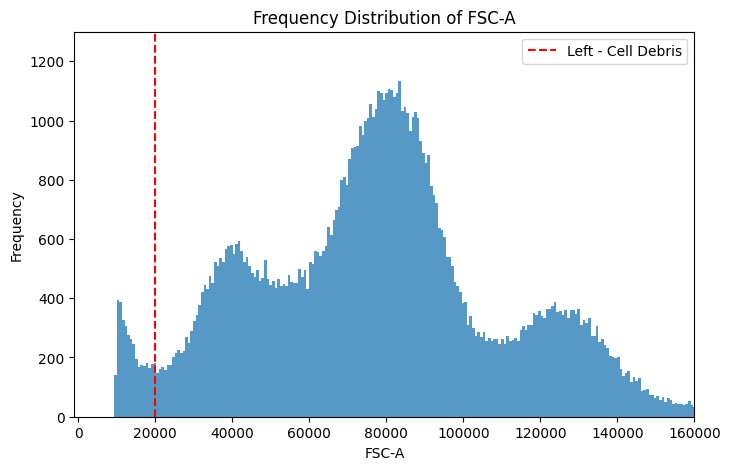

In [66]:
# Create a histogram
plt.figure(figsize=(8, 5))
sns.histplot(pbmc_r['FSC-A'], bins=100000, kde=False)

# Set plot labels and title
plt.title('Frequency Distribution of FSC-A')
plt.xlabel('FSC-A')
plt.ylabel('Frequency')

# Set x and y axis limits
plt.xlim(-1000, 160000)
plt.ylim(0, 1300)

# Determine the x-value for the vertical line
first_convex_x = 20000

# Draw the vertical line
plt.axvline(x=first_convex_x, color='red', linestyle='--', label='Left - Cell Debris')

# Add a legend to explain the line
plt.legend()

# Plot
plt.show()

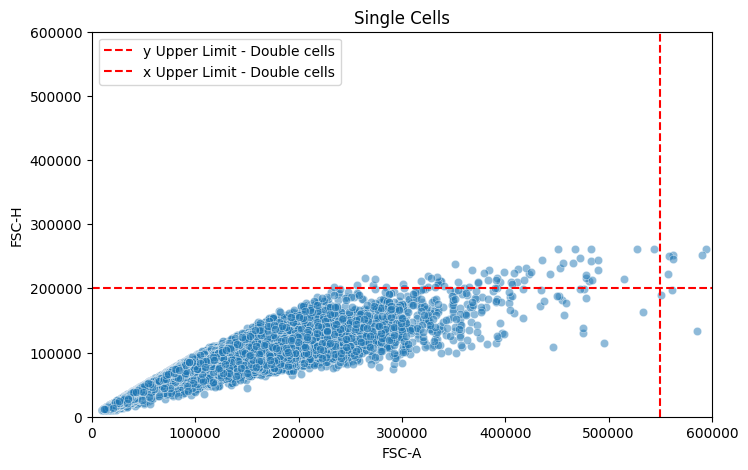

In [67]:
# Create the scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pbmc_r, x='FSC-A', y='FSC-H', alpha=0.5)

# Set plot labels and title
plt.title('Single Cells')
plt.xlabel('FSC-A')
plt.ylabel('FSC-H')

# Set x and y axis limits
plt.xlim(0, 600000)
plt.ylim(0, 600000)

# Determine the y-value for the horizontal line
y_lim = 200000  # Change this value based on the data

# Determine the x-value for the vertical line
x_lim = 550000  # Change this value based on the data

# Draw the horizontal line
plt.axhline(y=y_lim, color='red', linestyle='--', label='y Upper Limit - Double cells')

# Draw the vertical line
plt.axvline(x=x_lim, color='red', linestyle='--', label='x Upper Limit - Double cells')

# Add a legend to explain the lines
plt.legend()

# Show the plot
plt.show()

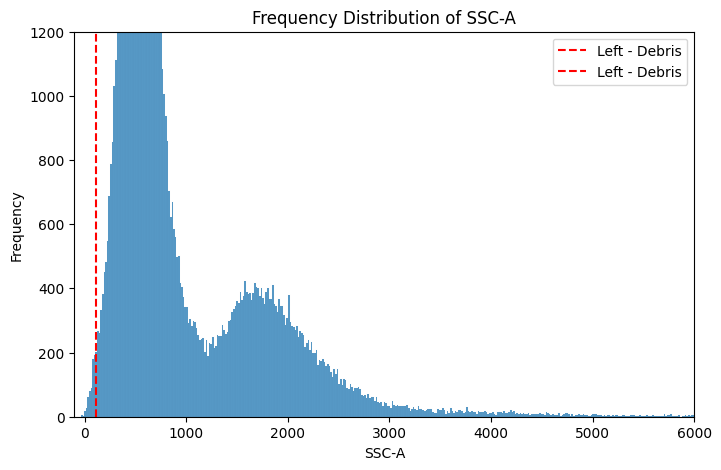

In [68]:
# Create a histogram
plt.figure(figsize=(8, 5))
sns.histplot(pbmc_r['SSC-A'], bins=10000)

# Set plot labels and title
plt.title('Frequency Distribution of SSC-A')
plt.xlabel('SSC-A')
plt.ylabel('Frequency')

# Set x and y axis limits
plt.xlim(-100, 6000)
plt.ylim(0, 1200)

# Determine the x-value for the vertical line
x_lower = 110                           # Change this value based on the data
x_upper = 20000                         # Change this value based on the data

# Draw the vertical line
plt.axvline(x=x_lower, color='red', linestyle='--', label='Left - Debris')
plt.axvline(x=x_upper, color='red', linestyle='--', label='Left - Debris')

# Add a legend to explain the line
plt.legend()

# Plot
plt.show()

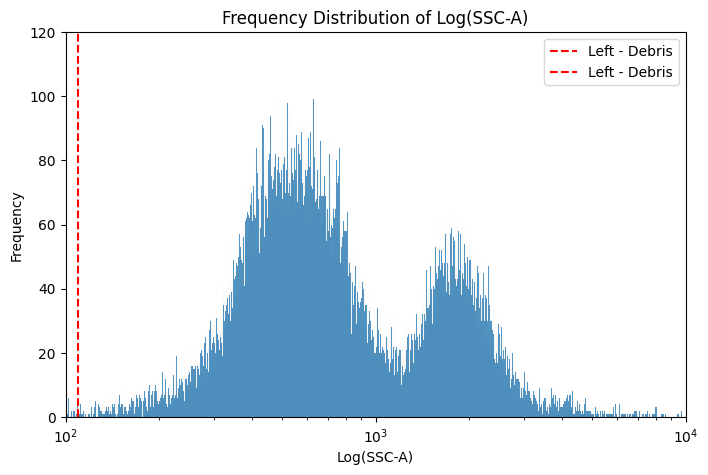

In [69]:
# Create a histogram
plt.figure(figsize=(8, 5))
sns.histplot(pbmc_r['SSC-A'], bins=10000, log_scale=True)

# Set plot labels and title
plt.title('Frequency Distribution of Log(SSC-A)')
plt.xlabel('Log(SSC-A)')
plt.ylabel('Frequency')

# Set x and y axis limits
plt.xlim(100, 10000)
plt.ylim(0, 120)

# Determine the x-value for the vertical line
x_lower = 110                           # Change this value based on the data
x_upper = 20000                         # Change this value based on the data

# Draw the vertical line
plt.axvline(x=x_lower, color='red', linestyle='--', label='Left - Debris')
plt.axvline(x=x_upper, color='red', linestyle='--', label='Left - Debris')

# Add a legend to explain the line
plt.legend()

# Plot
plt.show()

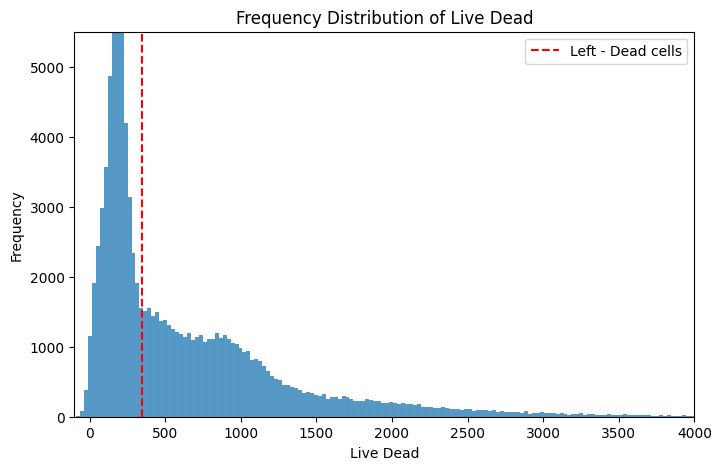

In [70]:
# Create a histogram
plt.figure(figsize=(8, 5))
sns.histplot(pbmc_r['Live Dead UV Blue'], bins=10000)

# Set plot labels and title
plt.title('Frequency Distribution of Live Dead')
plt.xlabel('Live Dead')
plt.ylabel('Frequency')

# Set x and y axis limits
plt.xlim(-100, 4000)
plt.ylim(0, 5500)

# Determine the x-value for the vertical line
x_lim = 350                        # Change this value based on the data

# Draw the vertical line
plt.axvline(x=x_lim, color='red', linestyle='--', label='Left - Dead cells')

# Add a legend to explain the line
plt.legend()

# Plot
plt.show()

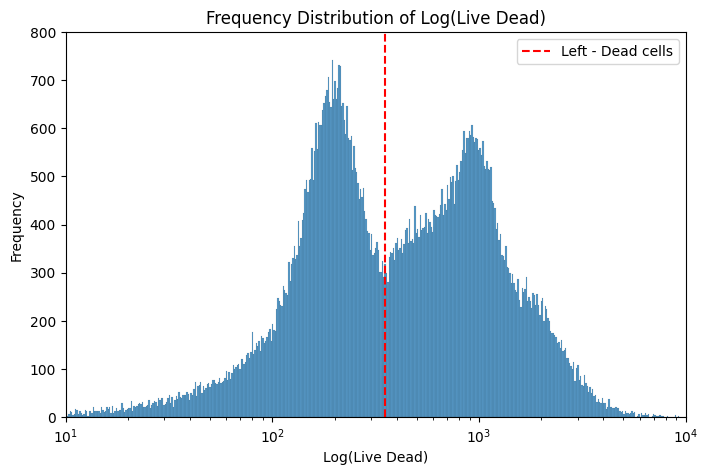

In [71]:
# Create a histogram
plt.figure(figsize=(8, 5))
sns.histplot(pbmc_r['Live Dead UV Blue'], bins=1000, log_scale=True)

# Set plot labels and title
plt.title('Frequency Distribution of Log(Live Dead)')
plt.xlabel('Log(Live Dead)')
plt.ylabel('Frequency')

# Set x and y axis limits
plt.xlim(10, 10000)
plt.ylim(0, 800)

# Determine the x-value for the vertical line
first_convex_x = 350                        # Change this value based on the data

# Draw the vertical line
plt.axvline(x=first_convex_x, color='red', linestyle='--', label='Left - Dead cells')

# Add a legend to explain the line
plt.legend()

# Plot
plt.show()

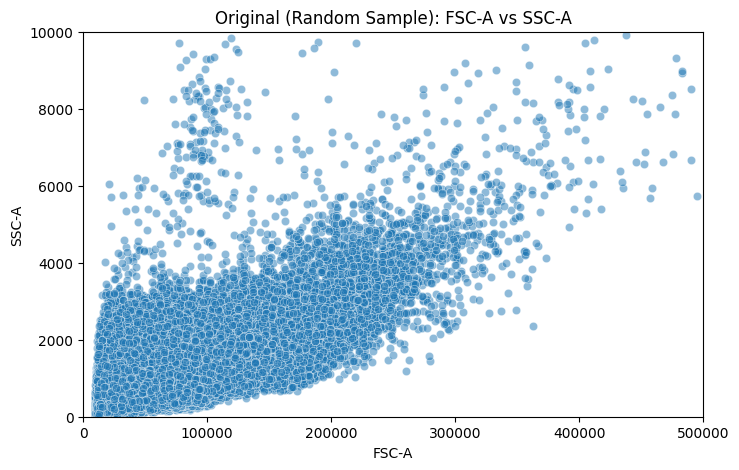

In [72]:
# Create the scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pbmc_r, x='FSC-A', y='SSC-A', alpha=0.5)

# Set plot labels and title
plt.title('Original (Random Sample): FSC-A vs SSC-A')
plt.xlabel('FSC-A')
plt.ylabel('SSC-A')

# Set x and y axis limits
plt.xlim(0, 500000)
plt.ylim(0, 10000)

# Plot
plt.show()

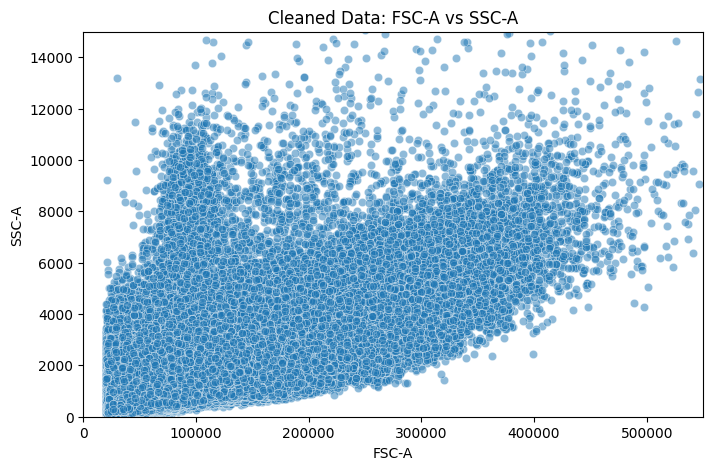

In [73]:
# Create the scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pbmc_s1_df, x='FSC-A', y='SSC-A', alpha=0.5)

# Set plot labels and title
plt.title('Cleaned Data: FSC-A vs SSC-A')
plt.xlabel('FSC-A')
plt.ylabel('SSC-A')

# Set x and y axis limits
plt.xlim(0, 550000)
plt.ylim(0, 15000)

# Plot
plt.show()

## Training, Validation, and Test Data sets

**Cleaned data sets to be used for Model Development and Testings**

In [74]:
# Upload Dataset from Google Drive
pbmc_clean = pd.read_csv("pbmc_clean.csv")

# Display the shape of the DataFrame
print("Number of instances and features:", pbmc_clean.shape)

Number of instances and features: (1045518, 13)


In [75]:
# Split the dataset into training + validation and test sets
train_val, test = train_test_split(pbmc_clean, test_size=0.2, random_state=42)  # 20% for test

# Now split the training + validation set into training and validation sets
train, val = train_test_split(train_val, test_size=0.25, random_state=42)       # 25% of 80% is 20%

# - train: 60% of the original data
# - val: 20% of the original data
# - test: 20% of the original data

## Reduce Dimensionality

PCA (Principal Component Analysis) - Most basic

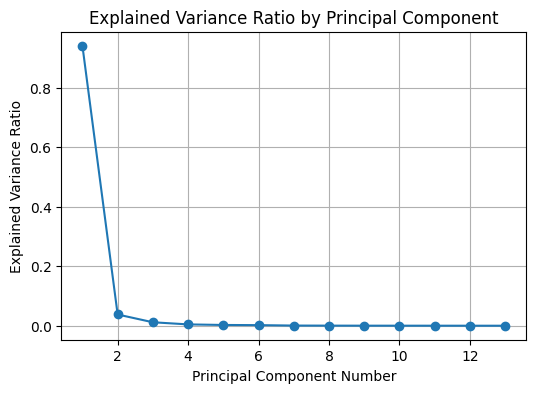

In [76]:
# Fit PCA on the training data
pca = PCA().fit(train)

# Plot the explained variance ratio
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance Ratio by Principal Component')
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()

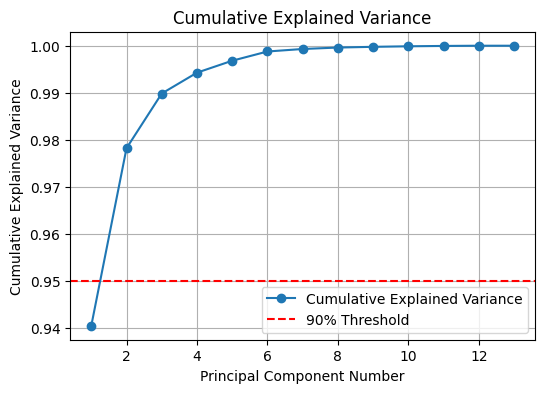

In [77]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cumulative_variance) + 1),
         cumulative_variance,
         marker='o',
         label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='90% Threshold')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component Number')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid()
plt.show()

PCA Train, Val, and Test Dataframes

In [78]:
# Perform PCA with 2 components
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train)
val_pca = pca.transform(val)
test_pca = pca.transform(test)

# Convert PCA results to DataFrame for easier plotting
train_pca_df = pd.DataFrame(data=train_pca, columns=['PC1', 'PC2'])
val_pca_df = pd.DataFrame(data=val_pca, columns=['PC1', 'PC2'])
test_pca_df = pd.DataFrame(data=test_pca, columns=['PC1', 'PC2'])

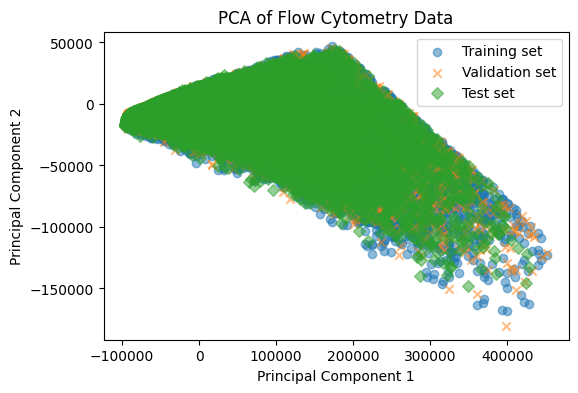

In [79]:
# Visualize the PCA results
plt.figure(figsize=(6, 4))
plt.scatter(train_pca_df['PC1'], train_pca_df['PC2'],
            alpha=0.5, label='Training set')
plt.scatter(val_pca_df['PC1'], val_pca_df['PC2'],
            alpha=0.5, label='Validation set', marker='x')
plt.scatter(test_pca_df['PC1'], test_pca_df['PC2'],
            alpha=0.5, label='Test set', marker='D')
plt.title('PCA of Flow Cytometry Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

t-SNE (t-distributed Stochastic Neighbor Embedding) - Most popularly used in Flow analysis after performing PCA

In [ ]:
# Use the PCA-transformed data for t-SNE
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
train_tsne = tsne.fit_transform(train_pca)                                       # Use PCA-transformed training data
val_tsne = tsne.fit_transform(val_pca)                                           # Use PCA-transformed validation data
test_tsne = tsne.fit_transform(test_pca)                                         # Use PCA-transformed test data

# Convert t-SNE results to DataFrame for easier plotting
train_tsne_df = pd.DataFrame(data=train_tsne, columns=['TSNE1', 'TSNE2'])
val_tsne_df = pd.DataFrame(data=val_tsne, columns=['TSNE1', 'TSNE2'])
test_tsne_df = pd.DataFrame(data=test_tsne, columns=['TSNE1', 'TSNE2'])

In [ ]:
# Visualize the t-SNE results
plt.figure(figsize=(6, 4))
plt.scatter(train_tsne_df['TSNE1'], train_tsne_df['TSNE2'],
            alpha=0.5, label='Training set')
plt.scatter(val_tsne_df['TSNE1'], val_tsne_df['TSNE2'],
            alpha=0.5, label='Validation set', marker='x')
plt.scatter(test_tsne_df['TSNE1'], test_tsne_df['TSNE2'],
            alpha=0.5, label='Test set', marker='D')
plt.title('t-SNE of Flow Cytometry Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

## Reduced Train, Val, and Test Sets: train_tsne, val_tsne_df, & test_tsne

## Model Development

### PBMC Test - (Initial MD)

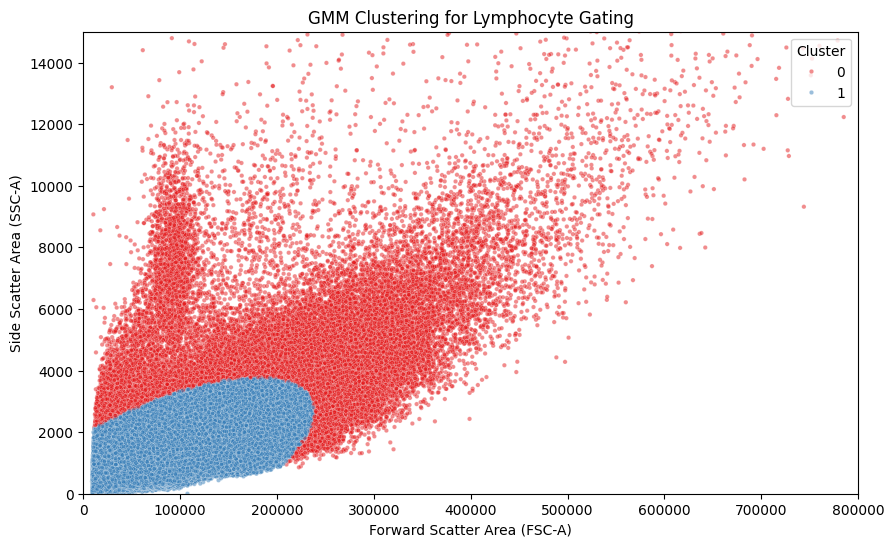

In [ ]:
fsc_a = pbmc[:, 'FSC-A'].astype('<f4')
ssc_a = pbmc[:, 'SSC-A'].astype('<f4')
data = pd.DataFrame({
    'FSC-A': fsc_a,
    'SSC-A': ssc_a
})

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['FSC-A', 'SSC-A']])

n_components = 2
gmm = GaussianMixture(n_components=n_components, n_init=10, max_iter=500, random_state=599)
gmm.fit(data_scaled)

data['Cluster'] = gmm.predict(data_scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(x='FSC-A', y='SSC-A', hue='Cluster', data=data, palette='Set1', s=10, alpha=0.5)
plt.xlabel('Forward Scatter Area (FSC-A)')
plt.ylabel('Side Scatter Area (SSC-A)')
plt.title('GMM Clustering for Lymphocyte Gating')
plt.xlim(0, 800000)
plt.ylim(0, 15000)
plt.legend(title='Cluster', loc='upper right')
plt.show()

### Model 1 - Type Name Here

### Model 2 - Type Name Here

### Model 3 - Type Name Here

## Model Performance Evaluation and Model Selection

### Cummulative AUC-ROC Plot and Accuracy Table

In [ ]:
# Cummulative AUC-ROC Plot




In [ ]:
# Compiled Accuracy Table




## Model Testing: non-conventional sample

In [ ]:
# AUC-ROC Plot




# Tableau or FLASK Release

# References

1. Beckman Coulter. (2022). Automatic gating - Beckman Coulter. Flow Cytometry. [https://www.beckman.com/flow-cytometry/software/cytobank-premium/learning-center/automatic-gating](https://www.beckman.com/flow-cytometry/software/cytobank-premium/learning-center/automatic-gating)

2. FlowRepository. (2020). FlowRepository ID FR-FCM-Z32U. Retrieved from [http://flowrepository.org/experiments/3166/download_ziped_files](http://flowrepository.org/experiments/3166/download_ziped_files)

3. Hu, Z., Bhattacharya, S., & Butte, A. J. (2022). Application of Machine Learning for Cytometry Data. *Frontiers in Immunology*, 12, 787574. [https://doi.org/10.3389/fimmu.2021.787574](https://doi.org/10.3389/fimmu.2021.787574)

4. Mair, F., & Leichti, T. (2020). Comprehensive Phenotyping of Human Dendritic Cells and Monocytes. *Journal of Quantitative Cell Science*, 99(3), 231-242. [https://doi.org/10.1002/cyto.a.24269](https://doi.org/10.1002/cyto.a.24269)

5. Maecker, H. T., McCoy, J. P., & Nussenblatt, R. (2012). Standardizing immunophenotyping for the Human Immunology Project. *Nature Reviews Immunology*, 12(3), 191–200. [https://doi.org/10.1038/nri3158](https://doi.org/10.1038/nri3158)

6. Ng, D. P., Simonson, P. D., Tarnok, A., Lucas, F., Kern, W., Rolf, N., Bogdanoski, G., Green, C., Brinkman, R. R., & Czechowska, K. (2024). Recommendations for using artificial intelligence in clinical flow cytometry. *Cytometry Part B: Clinical Cytometry*, 106(4), 228–238. [https://doi.org/10.1002/cyto.b.22166](https://doi.org/10.1002/cyto.b.22166)
